In [12]:
from time import time
import logging
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(__doc__)
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [13]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("height: %d" % h)
print("width: %d" % w)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
height: 50
width: 37


In [14]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# reshape to be [samples][pixels][width][height]

X_train = X_train.reshape(len(X_train), h, w, 1).astype('float32')
X_test = X_test.reshape(len(X_test), h, w, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

print("X_train shape:", X_train.shape)
print("train samples:", X_train.shape[0])
print("test samples:", X_test.shape[0])

X_train shape: (966, 50, 37, 1)
train samples: 966
test samples: 322


In [15]:
## Build the model
model = keras.Sequential([
    keras.Input(shape=(h,w,1,)),
    layers.Conv2D(32, kernel_size=(3, 3),activation ="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256),
    layers.Dense(n_classes, activation="softmax"),
    
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model
##model.fit(X_train, y_train, epochs=10, batch_size=128)
model.fit(X_train, y_train, epochs=20, batch_size=10)

## Evaluate the trained model
test_loss, test_acc = model.evaluate(X_test,  y_test)
print('\n Test accuracy:', test_acc)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


97/97 [==============================] - 3s 31ms/step - loss: 1.7091 - accuracy: 0.3996
Epoch 2/20
97/97 [==============================] - 3s 30ms/step - loss: 1.4011 - accuracy: 0.5135
Epoch 3/20
97/97 [==============================] - 3s 30ms/step - loss: 1.0586 - accuracy: 0.6366
Epoch 4/20
97/97 [==============================] - 3s 30ms/step - loss: 0.8306 - accuracy: 0.7195
Epoch 5/20
97/97 [==============================] - 3s 30ms/step - loss: 0.6270 - accuracy: 0.7971
Epoch 6/20
97/97 [==============================] - 3s 30ms/step - loss: 0.5518 - accuracy: 0.8106
Epoch 7/20
97/97 [==============================] - 3s 30ms/step - loss: 0.4350 - accuracy: 0.8551
Epoch 8/20
97/97 [==============================] - 3s 30ms/step - loss: 0.4060 - accuracy: 0.8747
Epoch 9/20
97/97 [==============================] - 3s 30ms/step - loss: 0.3658 - accuracy: 0.8892
Epoch 10/20
97/97 [==============================] - 3s 30ms/step - loss: 0.3500 - accuracy: 0.8778
Epoch 11/20
97/97 [=

In [16]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = np.argmax(model.predict(X_test), axis=1)
print("done in %0.3fs" % (time() - t0))
y_pred, y_test
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.257s
                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.77      0.80        13
     Colin Powell       0.85      0.95      0.90        60
  Donald Rumsfeld       0.95      0.67      0.78        27
    George W Bush       0.98      0.92      0.95       146
Gerhard Schroeder       0.74      0.80      0.77        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.70      0.97      0.81        36

         accuracy                           0.88       322
        macro avg       0.86      0.81      0.82       322
     weighted avg       0.90      0.88      0.88       322

[[ 10   1   1   0   0   0   1]
 [  0  57   0   1   0   0   2]
 [  2   1  18   1   4   0   1]
 [  0   2   0 135   3   0   6]
 [  0   2   0   0  20   0   3]
 [  0   4   0   0   0   9   2]
 [  0   0   0   1   0   0  35]]


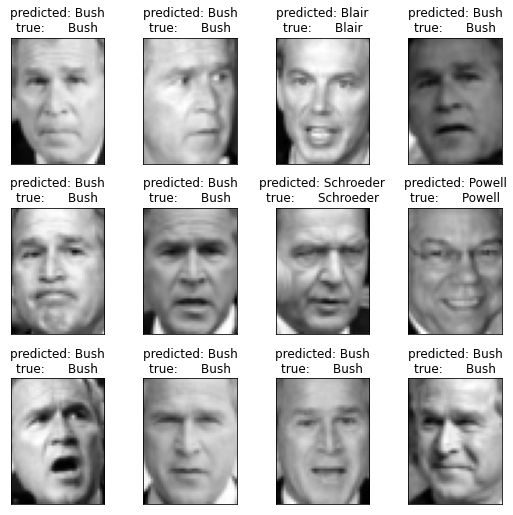

In [17]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

#eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
#plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()